# ERA Timeseries Generation

In [1]:
# Add Heatwave Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import ERA, Country, utils

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from scipy.ndimage import binary_closing

import calendar
import os

In [2]:
DATA_ROOT = os.path.abspath("../../data")
ERA_ROOT = os.path.join(DATA_ROOT, 'ERA')

# Utility Functions

In [3]:
def summer_indices(df: pd.DataFrame, extra_days: int=0):
    summer_series = []
    for year in np.unique(df.index.year):        
        if calendar.isleap(year):
            summer_series.append(df.loc[f"{23-extra_days}-06-{year}":f"{21+extra_days}-08-{year}"])
        else:
            summer_series.append(df.loc[f"{24-extra_days}-06-{year}":f"{22+extra_days}-08-{year}"])    
    return pd.concat(summer_series).values.ravel()

def plot_T95(T95, year):
    T95_std = T95.mean() + T95.std()

    # Create Big Figure
    plt.rcParams['figure.figsize'] = [15, 5]

    # Plot T95
    plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
    plt.plot(T95[year], c="black", label="T95")
    plt.axhline(T95_std, c="gray", linestyle="--", label="T95 Mean + STD")
    plt.fill_between(T95[year].index, T95_std, T95[year], where=T95[year] > T95_std,
                     interpolate=True, color="crimson", label="Heat Wave Events")

    plt.ylabel("T95 (°C)")
    plt.xlabel("Date")
    plt.xticks(rotation=-90)
    plt.ylim(-2, 12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create US Country Mask


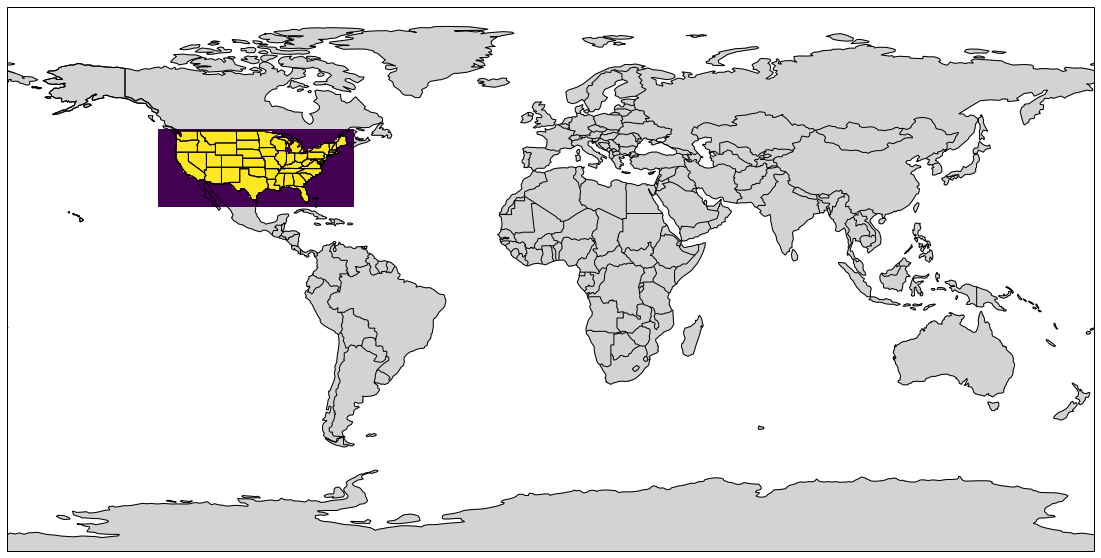

In [4]:
LSM_PATH = os.path.join(ERA_ROOT, 'landseamask_0.75deg.nc')
LSM = ERA(LSM_PATH, 'lsm')

US_LATITUDE_MASK = (LSM.latitude >= 24) * (LSM.latitude <= 50)
US_LONGITUDE_MASK = (LSM.longitude >= 230) * (LSM.longitude <= 295)

US_LATITUDE = LSM.latitude[US_LATITUDE_MASK]
US_LONGITUDE = LSM.longitude[US_LONGITUDE_MASK]

MASK_US = binary_closing(utils.era_country_mask(LSM_PATH) == Country.US) * LSM.data[0].astype(np.bool)

MASK_US = MASK_US[np.nonzero(US_LATITUDE_MASK)[0], :]
MASK_US = MASK_US[:, np.nonzero(US_LONGITUDE_MASK)[0]]

utils.plot_earth()
plt.pcolormesh(US_LONGITUDE, US_LATITUDE, MASK_US)
plt.show()

# Load ERA Temperature at 2 metres (T2M) Data

In [5]:
T2M_PATH = os.path.join(ERA_ROOT, 't2m_1979-2017_1_12_daily_0.75deg.nc')

# Preview T2M Dataset
T2M = ERA(T2M_PATH, 't2m')

# Load T2M Dataset Slice
T2M = ERA(T2M_PATH, 't2m', index=[
    summer_indices(T2M.time, extra_days=3),  # Only Load (Extended) Summer Days
    np.nonzero(US_LATITUDE_MASK)[0],         # Latitude for Mainland US
    np.nonzero(US_LONGITUDE_MASK)[0]         # Longitude for Mainland US
])

# Find Eastern US by Clustering ERA T2M Data based on T95

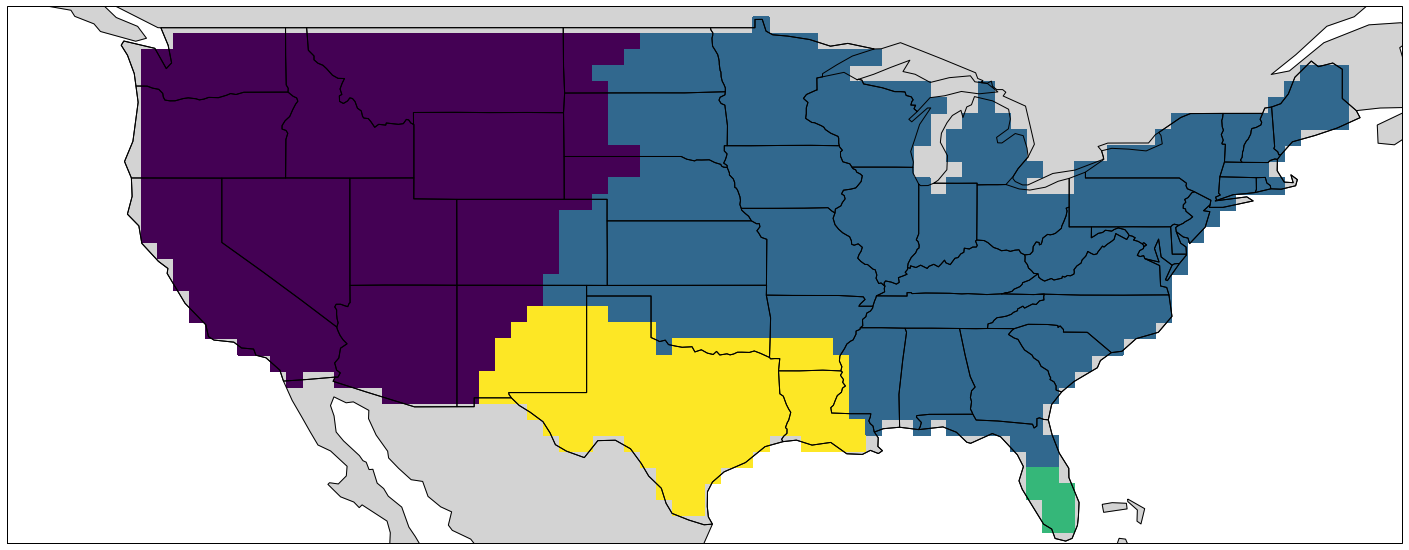

In [6]:
N = 4  # Number of Clusters

T2M_US = T2M.data[:, MASK_US]
T95_BOOL = T2M_US > np.quantile(T2M_US, 0.95, 0)

cluster = AgglomerativeClustering(N, affinity='jaccard', linkage='average')
cluster.fit(T95_BOOL.T)

# Create 2D Label Array
labels = np.empty(T2M.data.shape[1:])
labels.fill(np.nan)
labels[MASK_US] = cluster.labels_

# Identify East US Label,
east_label = np.argmax([np.mean(np.nonzero(labels == i)[1]) if np.sum(labels == i) > 20 else 0 for i in range(N)])
east_mask = labels == east_label
east_latitude = np.mean(np.nonzero(labels == east_label)[0])
east_longitude = np.mean(np.nonzero(labels == east_label)[1])

projection = utils.plot_earth("US")
plt.pcolormesh(US_LONGITUDE, US_LATITUDE, labels)
plt.savefig('cluster.png', dpi=300)
plt.show()

# Calculate T95 Heatwave Timeseries

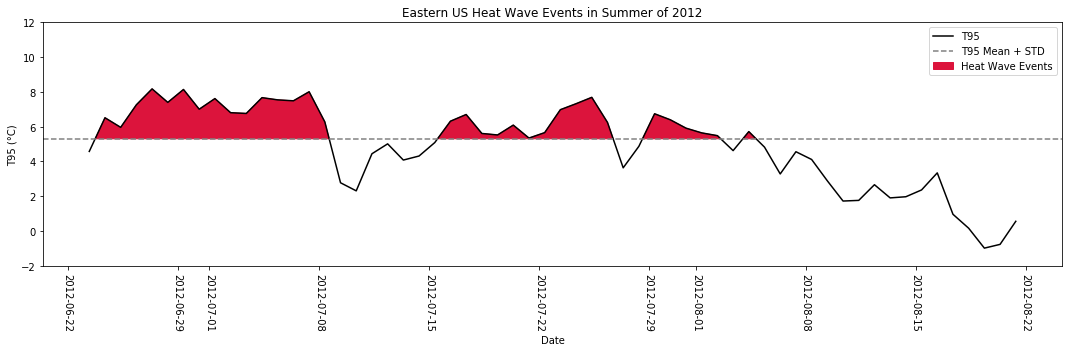

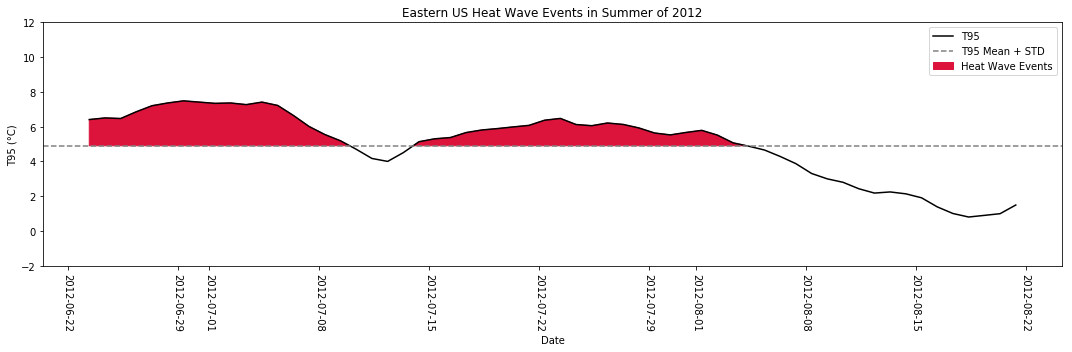

In [7]:
T95 = pd.DataFrame(T2M.anomaly[:, east_mask], index=T2M.time.index).quantile(0.95, 1)
T95_mean = T95.rolling(7, center=True).mean()

summer60 = summer_indices(T2M.time)

T95 = T95[summer60]
T95_mean = T95_mean[summer60]

plot_year = "2012"
plot_T95(T95, plot_year)
plot_T95(T95_mean, plot_year)

# Calculate Soil Moisture Timeseries

In [11]:
SM1_PATH = os.path.join(ERA_ROOT, 'sm1_1979-2017_1_12_daily_0.75deg.nc')
SM1 = ERA(SM1_PATH, 'swvl1', index=(None, np.nonzero(US_LATITUDE_MASK)[0], np.nonzero(US_LONGITUDE_MASK)[0]))

SM2_PATH = os.path.join(ERA_ROOT, 'sm2_1979-2017_1_12_daily_0.75deg.nc')
SM2 = ERA(SM2_PATH, 'swvl2', index=(None, np.nonzero(US_LATITUDE_MASK)[0], np.nonzero(US_LONGITUDE_MASK)[0]))

SM1_05 = pd.DataFrame(SM1.anomaly[:, east_mask], index=SM1.time.index).quantile(0.05, 1)
SM2_05 = pd.DataFrame(SM2.anomaly[:, east_mask], index=SM1.time.index).quantile(0.05, 1)

SM1_05.to_csv(os.path.join(DATA_ROOT, 'out', 'SM1_05.csv'))
SM2_05.to_csv(os.path.join(DATA_ROOT, 'out', 'SM2_05.csv'))

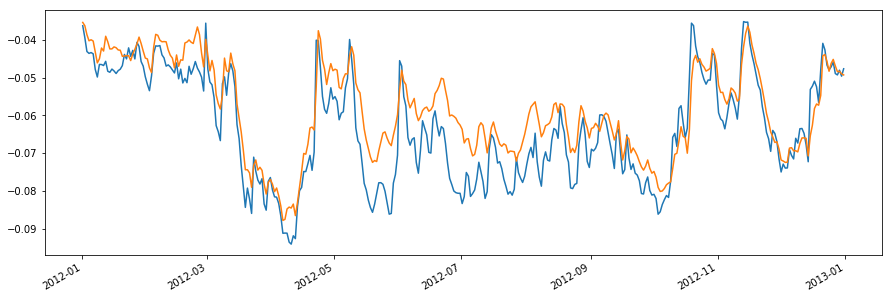

In [12]:
SM1_05["2012"].plot()
SM2_05["2012"].plot()
plt.show()